In [85]:
import os
os.getcwd()

'E:\\OneDrive - Johns Hopkins\\ML&Music-Yifan\\dan'

In [89]:
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import soundfile as sf
import os
import re
from IPython.display import Audio
rng = np.random.default_rng()

wavefile_folder="snippets2//"
L=os.listdir(wavefile_folder)
L=[x for x in L if re.search("wav",x)]
#print(L)

fileid=wavefile_folder+L[3]
print(fileid)
x,samplerate=sf.read(fileid)
print(samplerate)
print(x.shape)

#Audio(x[int(44100*2.78):int(44100*2.82)],rate=samplerate)
#Audio(x[int(44100*1.2):int(44100*2.2)],rate=samplerate)
#Audio(x[int(44100*1):int(44100*4)],rate=samplerate)
#plt.plot(x[int(44100*0):int(44100*4)])

snippets2//snippet_Amitabh003.wav
44100
(54298,)


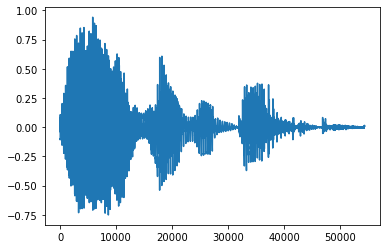

In [90]:
plt.plot(x)

3.0517578125e-05


0.05   -6.590545
0.10   -5.843331
0.15   -5.373327
0.20   -4.954790
0.25   -4.589065
0.30   -4.259481
0.35   -3.940438
0.40   -3.673616
0.45   -3.454085
0.50   -3.227858
0.55   -3.011977
0.60   -2.793709
0.65   -2.576768
0.70   -2.367449
0.75   -2.164236
0.80   -1.948807
0.85   -1.706826
0.90   -1.429206
0.95   -1.054397
dtype: float64

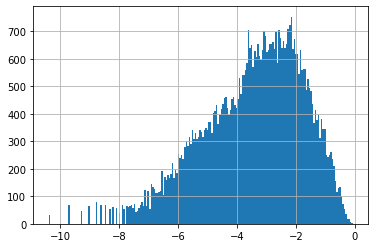

In [104]:
xabs=np.abs(x)
xabsposmin=np.min(xabs[xabs>0])
print(xabsposmin)
pd.Series(np.log(xabsposmin+np.abs(x))).hist(bins=200)
y=np.log(xabsposmin+np.abs(x))
pd.Series(y).quantile([i/20 for i in range(1,20)])

In [20]:
#Should we also get the percentile& mean of the actual amplitude percentile?
print(np.percentile(x,50))
print(np.percentile(x,25))
print(np.percentile(x,75))

0.000335693359375
-0.0101776123046875
0.033294677734375


In [22]:
print(np.mean(x))
print(np.var(x))

0.000276281652102323
0.015328659833323982


In [34]:
#window averaging
wsize=int(len(x)/100) # get the same N window each clip
wsize2=int(len(x)/1000)

In [35]:
def runningMean(x, N):
    y = np.zeros((len(x),))
    for ctr in range(len(x)):
         y[ctr] = np.sum(x[ctr:(ctr+N)])
    return y/N

2714


<AxesSubplot:>

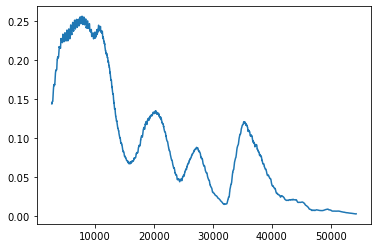

In [109]:
winsize=int(len(x)/20)
print(winsize)
pd.Series(x).abs().rolling(winsize).mean().plot()

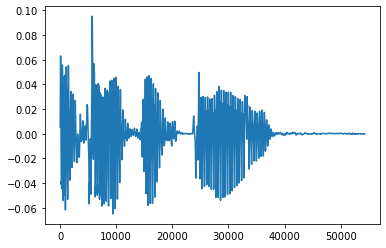

In [33]:
run_ave=runningMean(x,wsize)
plt.plot(run_ave)

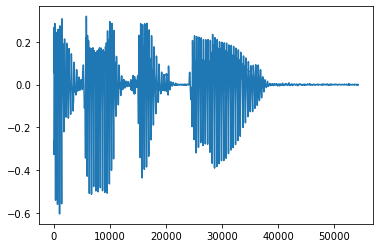

In [36]:
run_ave=runningMean(x,wsize2)
plt.plot(run_ave)

In [81]:
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import soundfile as sf
import os
import re
from IPython.display import Audio
#
# Given a signal x break it up into segments where we think the speaker 
# is speaking.
#
# First, take absolute value and normalize by dividing max value
#
# Repeat the following  
#
#     1) start interval at first value that is above initial_threshold
#     2) end interval at the first value starts at a window of duration wdur seconds
#        has its max below the kill threshold
#
# Remove all intervals whose duration is less than mindur seconds
#
def find_gaps(x,mindur,wdur, initial_threshold, kill_threshold):
    #
    # compute number of indices for mindur and wsecs
    #
    mindur_indices=int(mindur*44100)
    wdur_indices=int(wdur*44100)
    #
    #
    #
    print("mindur_indices = "+str(mindur_indices))
    print("wdur_indices= "+str(wdur_indices))
#     print("xlength = "+str(len(x)))
    
    #
    # normalize the signal
    #
    x=np.abs(x)
    M=np.max(x)
    x=x/M
    xt=x>=initial_threshold
    # print("number of x's above threshold ="+str(xt.sum()))
    #
    # compute indicator of max in windows below threshold
    #
    y=pd.Series(x).rolling(wdur_indices).max()
    y.to_csv("y.csv")
    #
    # remove the initial na's and find whose maximum is below threshold
    #
    y=np.array(y.iloc[wdur_indices-1:]<kill_threshold)
    #print("sum of y = "+str(np.sum(y)))
    pd.DataFrame({"xt":xt[0:len(y)],"y":y}).to_csv("out.csv")
    # print(y)
    # print("ylength = "+str(len(y)))
    # #
    # find next interval starting at position pos
    #
    def find_next_interval(x,y,pos,Nx,Ny):
        # print("in find next interval sum of x's "+str(x.sum()))
        # print(x)
        flag=False
        for i in range(pos,Nx):
            #print(x[i])
            if x[i]:
                flag=True
                break
        if not flag:
            return(None)
        start=i
        for i in range(start+1,Ny):
            if y[i]:
                end=i
                return((start,end))
        return((start,Nx))
    pos=0
    Nx=len(xt)
    Ny=len(y)
    L=[]
    while True:
        res=find_next_interval(xt,y,pos,Nx,Ny)
        if not res:
            return(L)
        pos=res[1]
        #print(res)
        #print(res[0]/44100,res[1]/44100)
        if res[1]-res[0]>=mindur_indices:
            L.append(res)
            #print(res[0]/44100,res[1]/44100)
    return(L)

wavefile_folder="../VoiceRecordings_3_6_23_danedited/"
L=os.listdir(wavefile_folder)
L=[x for x in L if re.search("wav",x)]
print(L)

def numb_to_string(n):
    if n<10:
        return("00"+str(n))
    if n<100:
        return("0"+str(n))


for x in L:
    fileid=wavefile_folder+x
    print(fileid)
    name=x.replace(".wav","")
    x,samplerate=sf.read(fileid)
    gaps=find_gaps(x,mindur=.5,wdur=.25,initial_threshold=.1,kill_threshold=.01)
    ctr=0
    for g in gaps:
        snippet=x[g[0]:g[1]]
        sf.write("snippets2//snippet_"+name+numb_to_string(ctr)+".wav",snippet,samplerate=44100)
        ctr+=1

['Amitabh.wav', 'DanAlphabet.wav', 'DanGa.wav', 'Dong.wav', 'Drew.wav', 'Eleanor.wav', 'Hamilton.wav', 'Ian.wav', 'Kaiwen.wav', 'Kate.wav', 'Kelsey.wav', 'Ningbo.wav', 'Philip.wav', 'Seehee.wav', 'Zachary.wav']
../VoiceRecordings_3_6_23_danedited/Amitabh.wav
mindur_indices = 22050
wdur_indices= 11025
../VoiceRecordings_3_6_23_danedited/DanAlphabet.wav
mindur_indices = 22050
wdur_indices= 11025
../VoiceRecordings_3_6_23_danedited/DanGa.wav
mindur_indices = 22050
wdur_indices= 11025
../VoiceRecordings_3_6_23_danedited/Dong.wav
mindur_indices = 22050
wdur_indices= 11025
../VoiceRecordings_3_6_23_danedited/Drew.wav
mindur_indices = 22050
wdur_indices= 11025
../VoiceRecordings_3_6_23_danedited/Eleanor.wav
mindur_indices = 22050
wdur_indices= 11025
../VoiceRecordings_3_6_23_danedited/Hamilton.wav
mindur_indices = 22050
wdur_indices= 11025
../VoiceRecordings_3_6_23_danedited/Ian.wav
mindur_indices = 22050
wdur_indices= 11025
../VoiceRecordings_3_6_23_danedited/Kaiwen.wav
mindur_indices = 2205

In [76]:
sf.write("snippet.wav",snippet,samplerate=44100)

In [75]:
help(sf.write)

Help on function write in module soundfile:

write(file, data, samplerate, subtype=None, endian=None, format=None, closefd=True)
    Write data to a sound file.
    
    .. note:: If `file` exists, it will be truncated and overwritten!
    
    Parameters
    ----------
    file : str or int or file-like object
        The file to write to.  See :class:`SoundFile` for details.
    data : array_like
        The data to write.  Usually two-dimensional (frames x channels),
        but one-dimensional `data` can be used for mono files.
        Only the data types ``'float64'``, ``'float32'``, ``'int32'``
        and ``'int16'`` are supported.
    
        .. note:: The data type of `data` does **not** select the data
                  type of the written file. Audio data will be
                  converted to the given `subtype`. Writing int values
                  to a float file will *not* scale the values to
                  [-1.0, 1.0). If you write the value ``np.array([42],
       